In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from torchsummary import summary
import time
import copy

import random

import os

In [2]:
from torchvision import datasets as ds
from torch.utils.data import DataLoader
from torchvision import transforms as ts
import torchvision as tv
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn
from PIL import Image
from tqdm import tqdm
import random
import os

%config Completer.use_jedi = False

In [3]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)

In [4]:
transform_train = ts.Compose([ts.ToTensor(),
                                      ts.RandomHorizontalFlip(p=0.2),
                                      ts.RandomVerticalFlip(p=0.2),
                                      ts.RandomGrayscale(p=0.2)
                                     ])

transform_validation = ts.Compose([
        ts.ToTensor()
])

transform  = ts.Compose([
        ts.ToTensor(),

])

In [5]:
trainset1 = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/share/cafir_10',
                                        train=True,
                                        download=True,
                                        transform=transform)

vaildset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/share/cafir_10',
                                        train=False,
                                        download=True,
                                        transform=transform_validation)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset2 = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/share/cafir_10',
                                        train=True,
                                        download=True,
                                        transform=transform_train)

Files already downloaded and verified


In [7]:
trainset = trainset1+trainset2

In [8]:
testset = torchvision.datasets.ImageFolder(root = "C:/Users/fkrdn/Desktop/Statistical_Deep_Image",
                                           transform = transform)

In [9]:
train_loader = DataLoader(trainset,
                          batch_size = 32,
                          shuffle=True,
                          num_workers=2)

vaild_loader = DataLoader(vaildset,
                          batch_size = 32,
                          shuffle=False,
                          num_workers=2)


test_loader = DataLoader(testset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2)

In [10]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)

In [11]:
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

In [12]:
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 4, stride=1, padding=1),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121():
    return DenseNet([6, 12, 24, 6])

In [13]:
model = DenseNet_121()

In [14]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cpu')

In [15]:
mode = model.to(device)

In [16]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-5)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [17]:
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':vaild_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models_densenet_bn/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models_densenet_bn')

In [21]:
model.eval()

DenseNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (dense_block_0): Sequential(
      (bottle_neck_layer_0): BottleNeck(
        (residual): Sequential(
          (0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU()
          (5): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (shortcut): Sequential()
      )
      (bottle_neck_layer_1): BottleNeck(
        (residual): Sequential(
          (0): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(36, 48

In [22]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs= model(images)
      _, predicted = torch.max(outputs.data,1)
      total +=labels.size(0)
      correct += (predicted == labels).sum().item()

print(100* correct/total)

48.675662168915544


In [18]:
model.load_state_dict(torch.load('models_densenet_bn/weights.pt'))

<All keys matched successfully>

In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [20]:
y_true = []
y_pred = []

for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.39it/s]


In [21]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [22]:
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

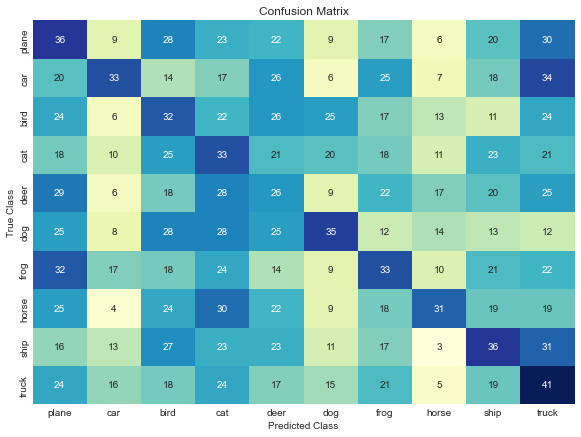

In [23]:
plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()